In [24]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import json
import random

In [14]:
working_dir = os.getcwd()
print(f"You are now working in {working_dir}")
print("If you need to change to the parent directory, run the cell below")

You are now working in c:\Users\fredd\Desktop\Studier\Project5\flowers\flowers_CNN
If you need to change to the parent directory, run the cell below


In [ ]:
os.chdir(os.path.dirname(working_dir))
new_working_dir = os.getcwd()
print(f"You have now changed your working directory to {new_working_dir}")

In [15]:
version = 'v2'
file_path = f'outputs/{version}'
current_working_dir = os.getcwd()

if 'outputs' in os.listdir(current_working_dir) and version in os.listdir(current_working_dir + '/outputs'):
    print("This version already exists, create a new version if you are working on a new version")
    pass
else:
    os.makedirs(name=file_path)

This version already exists, create a new version if you are working on a new version


In [16]:
image_dirs = 'inputs/dataset/raw/flower_photos'
train_path = image_dirs + '/train'
val_path = image_dirs + '/validation'
test_path = image_dirs + '/test'

In [17]:
labels = os.listdir(train_path)
print(f"Flower labels: {labels}")

Flower labels: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [18]:


class ImageClassificationPipeline:
    def __init__(self, train_path, val_path, test_path, input_shape=(224, 224, 3), batch_size=20, num_classes=5):
        self.train_path = train_path
        self.val_path = val_path
        self.test_path = test_path
        self.input_shape = input_shape
        self.batch_size = batch_size
        self.num_classes = num_classes

        # Initialize ImageDataGenerators
        self.train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.10,
            height_shift_range=0.10,
            shear_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='nearest'
        )
        self.val_test_datagen = ImageDataGenerator(rescale=1./255)

        # Build data generators
        self.train_set = self.train_datagen.flow_from_directory(
            self.train_path, target_size=self.input_shape[:2], batch_size=self.batch_size,
            class_mode='categorical', shuffle=True
        )
        self.validation_set = self.val_test_datagen.flow_from_directory(
            self.val_path, target_size=self.input_shape[:2], batch_size=self.batch_size,
            class_mode='categorical', shuffle=False
        )
        self.test_set = self.val_test_datagen.flow_from_directory(
            self.test_path, target_size=self.input_shape[:2], batch_size=self.batch_size,
            class_mode='categorical', shuffle=False
        )
        
        # Retrieve label map
        self.label_map = list(self.train_set.class_indices.keys())
        
        # Build model
        self.model = self.build_model()

    def build_model(self):
        model = Sequential([
            Conv2D(16, (3, 3), activation='relu', input_shape=self.input_shape),
            MaxPooling2D(pool_size=(2, 2)),
            Conv2D(32, (3, 3), activation='relu'),
            MaxPooling2D(pool_size=(2, 2)),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D(pool_size=(2, 2)),
            Flatten(),
            Dense(64, activation='relu'),
            Dropout(0.5),
            Dense(self.num_classes, activation='softmax')
        ])
        
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    def train(self, epochs=25, early_stopping_patience=3):
        early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stopping_patience, restore_best_weights=True)
        
        self.history = self.model.fit(
            self.train_set,
            validation_data=self.validation_set,
            epochs=epochs,
            callbacks=[early_stop],
            verbose=1
        )

    def evaluate(self, savepath=None,  cm_image_path=None): 
        y_pred_probs = self.model.predict(self.test_set)
        y_pred = np.argmax(y_pred_probs, axis=1)
        y_true = self.test_set.classes

        # Calculate F1 score
        f1 = f1_score(y_true, y_pred, average='weighted')
        print(f"F1 Score (weighted): {f1:.4f}")

        # Classification report
        report = classification_report(y_true, y_pred, target_names=self.label_map, output_dict=True)
        print("\nClassification Report:")
        print(report)

        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.label_map)
        disp.plot(cmap=plt.cm.Blues)
        plt.show()

        if cm_image_path:
            disp.plot(cmap=plt.cm.Blues)
            plt.savefig(cm_image_path, bbox_inches='tight', dpi=150)
            print(f"Confusion matrix image saved as {cm_image_path}")
        
        # If savepath is given, save JSON-file
        if savepath:
            evaluation_data = {
                "f1_score_weighted": f1,
                "classification_report": report,
                "confusion_matrix": cm.tolist()  # Converts numpy array to list for JSON-file
            }

            # Saves data as JSON-file
            with open(savepath, 'w') as f:
                json.dump(evaluation_data, f, indent=4)
            print(f"Evaluation saved as {savepath}")

    def plot_training_history(self, savepath):
        plt.figure(figsize=(12, 5))
        
        # Accuracy plot
        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['accuracy'], label='Train Accuracy')
        plt.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()

        # Loss plot
        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['loss'], label='Train Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()

        plt.tight_layout()
        plt.savefig(savepath, bbox_inches='tight', dpi=150)
        plt.show()


    def save_model(self, filepath):
        self.model.save(filepath)
        print(f"Model saved as {filepath}")
        
    def model_summary(self):
        self.model.summary()

In [19]:
pipeline = ImageClassificationPipeline(train_path, val_path, test_path)
pipeline.train(epochs=25)
pipeline.save_model(f"{file_path}/flower_prediction_model.h5")


Found 20549 images belonging to 5 classes.
Found 2934 images belonging to 5 classes.
Found 5877 images belonging to 5 classes.


C:\Users\fredd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\fredd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 336s 325ms/step - accuracy: 0.4035 - loss: 1.3926 - val_accuracy: 0.5924 - val_loss: 0.9562
Epoch 2/25
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 322s 313ms/step - accuracy: 0.5881 - loss: 1.0364 - val_accuracy: 0.6622 - val_loss: 0.8191
Epoch 3/25
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 322s 314ms/step - accuracy: 0.6300 - loss: 0.9450 - val_accuracy: 0.6466 - val_loss: 0.8812
Epoch 4/25
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 340s 331ms/step - accuracy: 0.6455 - loss: 0.9009 - val_accuracy: 0.7127 - val_loss: 0.7522
Epoch 5/25
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 323s 314ms/step - accuracy: 0.6711 - loss: 0.8533 - val_accuracy: 0.7134 - val_loss: 0.7290
Epoch 6/25
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 321s 313ms/step - accuracy: 0.6941 - loss: 0.8047 - val_accuracy: 0.7464 - val_loss: 0.6492
Epoch 7/25
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 319s 311ms/step - accuracy: 0.7034 - loss: 0.7717 - val_accuracy: 0.7590 - val_loss: 0.6295
Epoch 8/25
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 320s 311ms/step - ac

Model saved as outputs/v2/flower_prediction_model.h5


294/294 ━━━━━━━━━━━━━━━━━━━━ 29s 99ms/step
F1 Score (weighted): 0.8244

Classification Report:
{'daisy': {'precision': 0.8886597938144329, 'recall': 0.8500986193293886, 'f1-score': 0.8689516129032258, 'support': 1014.0}, 'dandelion': {'precision': 0.8068799034399518, 'recall': 0.9297635605006954, 'f1-score': 0.8639741518578352, 'support': 1438.0}, 'roses': {'precision': 0.7343599615014437, 'recall': 0.7429406037000974, 'f1-score': 0.7386253630203291, 'support': 1027.0}, 'sunflowers': {'precision': 0.8983666061705989, 'recall': 0.8847184986595175, 'f1-score': 0.8914903196758217, 'support': 1119.0}, 'tulips': {'precision': 0.8124436429215509, 'recall': 0.7044566067240031, 'f1-score': 0.7546063651591289, 'support': 1279.0}, 'accuracy': 0.8257614429130509, 'macro avg': {'precision': 0.8281419815695956, 'recall': 0.8223955777827404, 'f1-score': 0.823529562523268, 'support': 5877.0}, 'weighted avg': {'precision': 0.8269473650056205, 'recall': 0.8257614429130509, 'f1-score': 0.824366040910853

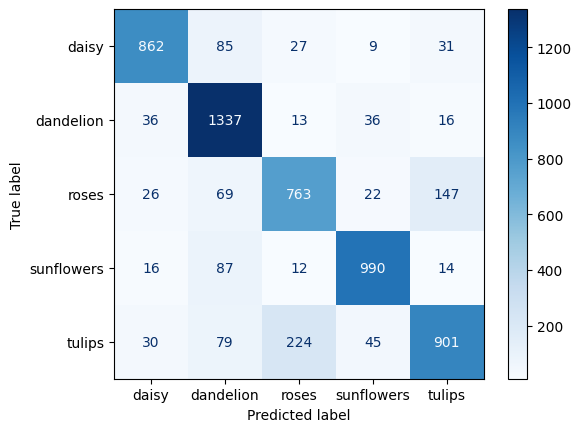

Confusion matrix image saved as outputs/v2/confusion_matrix.png
Evaluation saved as outputs/v2/model_evaluation.json


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     2,768,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,378,609 (31.96 MB)

 Trainable params: 2,792,869 (10.65 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,585,740 (21.31 MB)

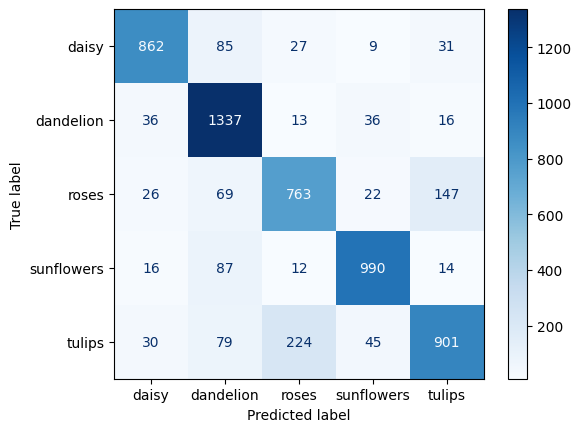

In [20]:
pipeline.evaluate(savepath=f"{file_path}/model_evaluation.json", cm_image_path=f"{file_path}/confusion_matrix.png")
pipeline.model_summary()

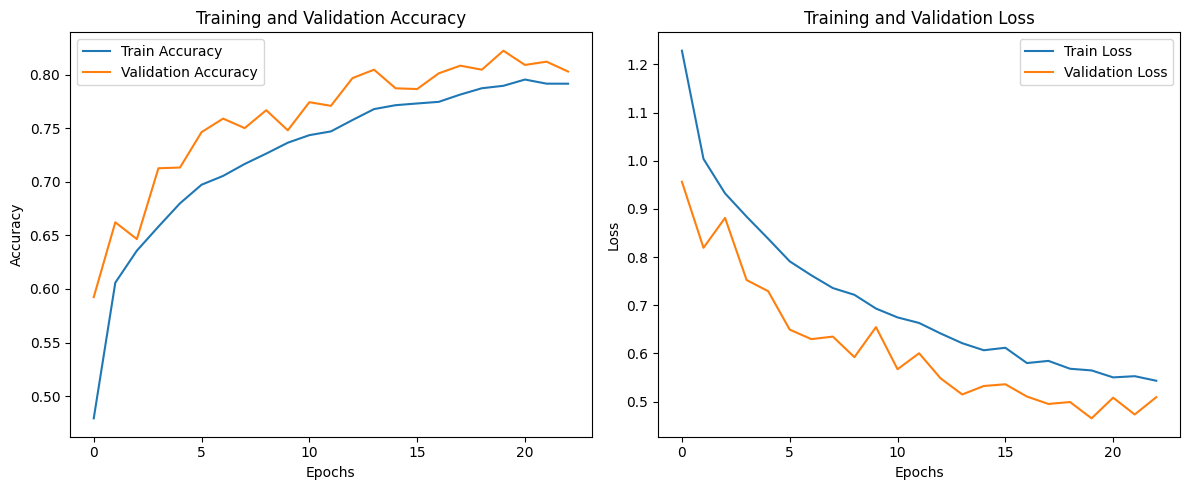

In [22]:
pipeline.plot_training_history(savepath=f"{file_path}/training_history.png")

In [23]:
json_file = f"{file_path}/model_evaluation.json"

with open(json_file, 'r') as f:
    evaluation_data = json.load(f)
    
print(f"Weighted F1 Score: {evaluation_data['f1_score_weighted']:.4}\n")


# Transforms the JSON-file to a more readable DataFrame
classification_report_df = pd.DataFrame(evaluation_data['classification_report']).transpose()
classification_report_df = classification_report_df.round(4)

classification_report_df = pd.concat([
    classification_report_df.iloc[:-3],  
    pd.DataFrame([[''] * len(classification_report_df.columns)], columns=classification_report_df.columns),  
    classification_report_df.iloc[-3:]  
]).reset_index()

classification_report_df.index.name = None

pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.width', 100)

print("Classification Report:\n", classification_report_df.to_string(index=False))

# Creates a DataFrame for the confussion matrix
labels = list(evaluation_data['classification_report'].keys())[:-3] # Excludes the last 3 labels
confussion_matrix_df = pd.DataFrame(
    evaluation_data['confusion_matrix'],
    index = labels,
    columns = labels
)

print("\nConfussion Matrix:\n", confussion_matrix_df)



Weighted F1 Score: 0.8244

Classification Report:
    index     precision  recall f1-score support
       daisy   0.8887   0.8501   0.869   1014.0
   dandelion   0.8069   0.9298   0.864   1438.0
       roses   0.7344   0.7429  0.7386   1027.0
  sunflowers   0.8984   0.8847  0.8915   1119.0
      tulips   0.8124   0.7045  0.7546   1279.0
           0                                   
    accuracy   0.8258   0.8258  0.8258   0.8258
   macro avg   0.8281   0.8224  0.8235   5877.0
weighted avg   0.8269   0.8258  0.8244   5877.0

Confussion Matrix:
             daisy  dandelion  roses  sunflowers  tulips
daisy        862       85       27         9        31 
dandelion     36     1337       13        36        16 
roses         26       69      763        22       147 
sunflowers    16       87       12       990        14 
tulips        30       79      224        45       901 


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


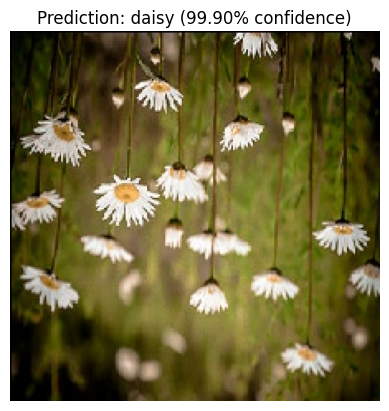

In [ ]:
def predict_random_image(model, label_map, img_path, target_size=(224, 224)):
    
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array /= 255.0  

    # Makes a prediction of a random image
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    predicted_label = label_map[predicted_class]
    confidence = predictions[0][predicted_class] * 100


    plt.imshow(img)
    plt.title(f"Prediction: {predicted_label} ({confidence:.2f}% confidence)")
    plt.axis('off')
    plt.show()


test_dir = "inputs/dataset/raw/flower_photos/test"  
random_class = random.choice(os.listdir(test_dir))  # Choose a random image
random_img_path = os.path.join(test_dir, random_class, random.choice(os.listdir(os.path.join(test_dir, random_class))))

# Prediction of an image
predict_random_image(pipeline.model, pipeline.label_map, random_img_path)

<hr>

## Results


| Version | Balanced / Unbalanced | Layers           | Total params   | Runtime | Accuracy | F1-Score | Comments                                                        |
| ------- | --------------------- | ---------------- | -------------- | ------- | -------- | -------- | --------------------------------------------------------------- |
| 1       | Unbalanced            | 32 - 64 - 128    | 33,508,817     | 209 min | 0.8329   | 0.8336   | Good result, though very large model file. Going to half the layers and see if the result will be the same and lesser size of the .h5-file |
| 2       | Unbalanced            | 16 - 32 - 64     | 8,378,609      | 124 min | 0.8258   | 0.8244   | Good result, almost the same result when decreasing the layers to the half of the first version. The model now are around 33Mb instead of over 130Mb with the first model |
